In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import gc
import ujson
from pymer4.models import Lmer
from pickle_cache import PickleCache
import itertools
from tqdm.auto import tqdm
import rs_utils

pcache = PickleCache('.cache')

sns.set()

In [2]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(CRATES)
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


gc.disable()
all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs
gc.enable()

df = df[(df.num_relevant_instructions != 0)]
df['ins_rel_nonzero'] = df.instructions_relative > 0

../data/rav1e.json
../data/hyper.json../data/image.json

../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json
../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
len(df.function_path.unique())

14520

In [4]:
len(df)/8

416957.0

In [5]:
best_df = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'Recurse') & (df.pointer_mode == 'Precise')]
best_df_over_z = best_df[best_df.instructions_relative > 0].sort_values(['num_instructions'])
len(best_df_over_z)

0

In [6]:
best_df_over_z

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,duration,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero


In [7]:
row = df.loc[151736]
df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,duration,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero
151736,151736,DistinguishMut,Recurse,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001684,True,False,False,True,0,0.0,True,rav1e,False
151737,151737,DistinguishMut,Recurse,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001750,True,False,False,True,0,0.0,True,rav1e,False
151738,151738,DistinguishMut,SigOnly,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001688,True,False,False,False,0,0.0,True,rav1e,False
151739,151739,DistinguishMut,SigOnly,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001699,True,False,False,False,0,0.0,True,rav1e,False
151740,151740,IgnoreMut,Recurse,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001697,True,False,False,True,0,0.0,True,rav1e,False
151741,151741,IgnoreMut,Recurse,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001763,True,False,False,True,0,0.0,True,rav1e,False
151742,151742,IgnoreMut,SigOnly,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001712,True,False,False,False,0,0.0,True,rav1e,False
151743,151743,IgnoreMut,SigOnly,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,0.001755,True,False,False,False,0,0.0,True,rav1e,False


In [8]:
row.function_path

'rav1e[8787]::cdef::rust::cdef_filter_block'

In [9]:
row

index                                                                     151736
mutability_mode                                                   DistinguishMut
context_mode                                                             Recurse
pointer_mode                                                             Precise
sliced_local                                                                 375
function_range                 {'start_line': 199, 'start_col': 2, 'end_line'...
function_path                         rav1e[8787]::cdef::rust::cdef_filter_block
num_instructions                                                            1237
num_relevant_instructions                                                    181
num_tokens                                                                  3110
num_relevant_tokens                                                          207
duration                                                              0.00168448
has_immut_ptr_in_call       

In [10]:
df = pcache.get('df', lambda: df, force=True)

In [11]:
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

/raid/wcrichto/rust-slicer/.env/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
df2 = df
df2 = df2[(df2.pointer_mode == 'Precise') & (df2.mutability_mode == 'IgnoreMut') & (df2.context_mode == 'Recurse')]
df2[df2.num_instructions < 1000].sort_values('instructions_relative_frac', ascending=False)[:20]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
1829468,606060,IgnoreMut,Recurse,Precise,1,"{'start_line': 649, 'start_col': 4, 'end_line'...",rustpython_vm[8787]::exceptions::{impl#4}::extend,959,304,4213,...,True,False,False,True,303,303.0,False,RustPython,True,5.713733
1165196,247956,IgnoreMut,Recurse,Precise,1,"{'start_line': 80, 'start_col': 4, 'end_line':...",image[8787]::codecs::pnm::decoder::{impl#0}::fmt,940,298,5953,...,True,False,False,True,297,297.0,False,image,True,5.693732
453372,453372,IgnoreMut,Recurse,Precise,4,"{'start_line': 1362, 'start_col': 0, 'end_line...",rav1e[8787]::rdo::intra_frame_rdo_mode_decision,966,280,11121,...,True,True,False,True,279,279.0,False,rav1e,True,5.631212
453388,453388,IgnoreMut,Recurse,Precise,6,"{'start_line': 1362, 'start_col': 0, 'end_line...",rav1e[8787]::rdo::intra_frame_rdo_mode_decision,966,280,11121,...,True,True,False,True,279,279.0,False,rav1e,True,5.631212
453396,453396,IgnoreMut,Recurse,Precise,7,"{'start_line': 1362, 'start_col': 0, 'end_line...",rav1e[8787]::rdo::intra_frame_rdo_mode_decision,966,280,11121,...,True,True,False,True,279,279.0,False,rav1e,True,5.631212
453348,453348,IgnoreMut,Recurse,Precise,1,"{'start_line': 1362, 'start_col': 0, 'end_line...",rav1e[8787]::rdo::intra_frame_rdo_mode_decision,966,280,11121,...,True,True,False,True,279,279.0,False,rav1e,True,5.631212
453380,453380,IgnoreMut,Recurse,Precise,5,"{'start_line': 1362, 'start_col': 0, 'end_line...",rav1e[8787]::rdo::intra_frame_rdo_mode_decision,966,280,11121,...,True,True,False,True,279,279.0,False,rav1e,True,5.631212
1867956,644548,IgnoreMut,Recurse,Precise,1,"{'start_line': 294, 'start_col': 0, 'end_line'...",rustpython_vm[8787]::stdlib::signal::extend_mo...,978,271,1785,...,True,False,False,True,270,270.0,False,RustPython,True,5.598422
3328492,187428,IgnoreMut,Recurse,Precise,1,"{'start_line': 295, 'start_col': 4, 'end_line'...",sccache[8787]::server::{impl#0}::create_state,937,270,7457,...,True,False,False,True,269,269.0,False,sccache,True,5.594711
1867964,644556,IgnoreMut,Recurse,Precise,2,"{'start_line': 294, 'start_col': 0, 'end_line'...",rustpython_vm[8787]::stdlib::signal::extend_mo...,978,266,1785,...,True,False,False,True,265,265.0,False,RustPython,True,5.579730


In [13]:
df

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
0,0,DistinguishMut,Recurse,Precise,0,"{'start_line': 17, 'start_col': 2, 'end_line':...",rav1e[8787]::cpu_features::rust::{impl#0}::def...,2,2,36,...,False,False,False,False,0,0.0,False,rav1e,False,-inf
1,1,DistinguishMut,Recurse,Conservative,0,"{'start_line': 17, 'start_col': 2, 'end_line':...",rav1e[8787]::cpu_features::rust::{impl#0}::def...,2,2,36,...,False,False,False,False,0,0.0,False,rav1e,False,-inf
2,2,DistinguishMut,SigOnly,Precise,0,"{'start_line': 17, 'start_col': 2, 'end_line':...",rav1e[8787]::cpu_features::rust::{impl#0}::def...,2,2,36,...,False,False,False,False,0,0.0,False,rav1e,False,-inf
3,3,DistinguishMut,SigOnly,Conservative,0,"{'start_line': 17, 'start_col': 2, 'end_line':...",rav1e[8787]::cpu_features::rust::{impl#0}::def...,2,2,36,...,False,False,False,False,0,0.0,False,rav1e,False,-inf
4,4,IgnoreMut,Recurse,Precise,0,"{'start_line': 17, 'start_col': 2, 'end_line':...",rav1e[8787]::cpu_features::rust::{impl#0}::def...,2,2,36,...,False,False,False,False,0,0.0,False,rav1e,False,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339587,198523,DistinguishMut,SigOnly,Conservative,5,"{'start_line': 191, 'start_col': 8, 'end_line'...",sccache[8787]::cache::gcs::deserialize_gcp_key...,12,2,2523,...,True,False,False,False,0,0.0,False,sccache,False,-inf
3339588,198524,IgnoreMut,Recurse,Precise,5,"{'start_line': 191, 'start_col': 8, 'end_line'...",sccache[8787]::cache::gcs::deserialize_gcp_key...,12,5,2523,...,True,False,False,True,3,1.5,False,sccache,True,0.405465
3339589,198525,IgnoreMut,Recurse,Conservative,5,"{'start_line': 191, 'start_col': 8, 'end_line'...",sccache[8787]::cache::gcs::deserialize_gcp_key...,12,5,2523,...,True,False,False,True,3,1.5,False,sccache,True,0.405465
3339590,198526,IgnoreMut,SigOnly,Precise,5,"{'start_line': 191, 'start_col': 8, 'end_line'...",sccache[8787]::cache::gcs::deserialize_gcp_key...,12,5,2523,...,True,False,False,False,3,1.5,False,sccache,True,0.405465


**Examples of big differences**

* modular vs whole-program
  * image (imageops/mod.rs:34) -- crop function passes &mut Image to container SubImage::new which doesn't modify the image, so recursing recognizes lack of mutation
    * rayon (slice/mod.rs:1139) -- passing pointer to container, same thing
  * rg3d (renderer/debug_renderer.rs:83) -- framebuffer.draw takes &mut self as input but doesn't safely mutate framebuffer, only indirectly through OpenGL calls
    * rg3d (renderer/shadow_map_renderer:443) -- same thing
    * image (buffer.rs:1115) -- unsafe pointer copying doesn't get registered as relevant during recurse
  * nalgebra (linalg/full_piv_lu.rs:188) -- return value of function is a simple boolean that doesn't involve most inputs, but SigOnly conservatively assumes all inputs are relevant
    * nalgebra (sparse/cs_matrix_ops.rs:234) -- function influencing value of `nz` has many parameters, but only some actually influence its value, while SigOnly conservatively assumes all are relevant
* distinguish vs not mutation
  * rustls (quic.rs:156) -- iter() produces immut pts to vec, then ^= actually calls function BitXor::... which takes the immut ptr and could naively modify it. Recurse doesn't help b/c ^= is stdlib function.
  * rocket (router/collider.rs:159) -- immut ptrs to fields are recursively passed to functions that could naively modify them. Recurse doesn't help b/c called funcs are trait methods and not resolves.
  * image (codecs/pnm/decoder.rs:80) -- format has many functions that read data
  * rg3d (renderer/sruface.rs:445) -- `data.transform_geometry(transform)` takes immut ptr to transform, but naively could be modified, so `data` is relevant and whole function contributes to `data`
* conservative vs precise
  * image (codecs/gif.rs:458) -- function call causes lifetime to get equal to static, hence aliasing all function data, and has non-intuitive flow-insensitive effects
  * rg3d (resource/fbx/scene/mod.rs:145) -- two inputs could alias, and therefore mutations are indistinguishable
  * rustls (msgs/handshake.rs:70) -- opaque.clone_from_slice(bytes), implicit (&mut opaque) is assumed to alias bytes and bytes is a slice of Reader, therefore mutation

In [14]:
# row = df.loc[636356]
# df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

# Dataset summary

## Lines of code

In [15]:
def compute_loc(grp):
    rng = grp.iloc[0].function_range
    return rng['end_line'] - rng['start_line'] + 1

total_loc = df.groupby('function_path').apply(compute_loc).sum()
total_loc

173108

In [16]:
#df2 = df.groupby(['crate', 'function_path']).apply(compute_loc)#.groupby('crate').sum()
g = df2.reset_index().groupby('crate')
out = g.sum()
out['size'] = g.size()
out

,level_0,index,sliced_local,num_instructions,num_relevant_instructions,num_tokens,num_relevant_tokens,duration,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,ins_rel_nonzero,ins_rel_frac_log,size
crate,,,,,,,,,,,,,,,,,,
rav1e,22300643556,22300643556,52811907,266981680,15513488,661841304,26099904,856.935668,62113,13468,2766,51480,1061488,135469.907363,47012,28618,-inf,74667
hyper,30278250996,6396160380,10412967,67687149,15343169,148768736,4671117,3739.034207,38050,34332,0,35060,12724230,505167.910942,33227,28562,-inf,39981
image,40846190812,5839726212,2530439,16092296,1650107,222064530,2189675,68.899540,30671,7541,99,27728,265857,46759.631738,24966,9847,-inf,38165
RustPython,151879497064,35995844488,10758040,82849265,5446063,649238360,5836720,5977.160017,92014,5542,22,81495,2938916,653361.783961,65615,48651,-inf,94722
rg3d,135335595600,14787266736,4320166,29494959,3476281,3203346875,6334930,863.189290,45762,4568,199,43594,970971,88441.804543,37997,20662,-inf,60798
rayon,26458164348,445310908,228909,1517848,219381,19323245,336096,3.088782,7209,2092,102,5175,14991,6140.512101,4313,2346,-inf,10535
rustls,62654608616,2240782760,1505035,10091781,1631818,93939640,2343418,368.951977,22172,8152,384,18940,863102,72634.919441,16366,12129,-inf,23658
Rocket,35239497900,636552900,1091190,6535880,1267088,21539144,556237,399.432027,10904,994,0,9406,1061883,86517.685479,7578,6149,-inf,12615
nalgebra,111150130356,5518409796,2841392,16375065,1376848,115128767,1865601,35.128536,34198,501,108,25392,190250,54423.143033,21070,16896,-inf,37143


## Execution time

In [17]:
df.duration.sum() / (3600 * 24)

0.8563702239970071

<AxesSubplot:xlabel='duration', ylabel='Count'>

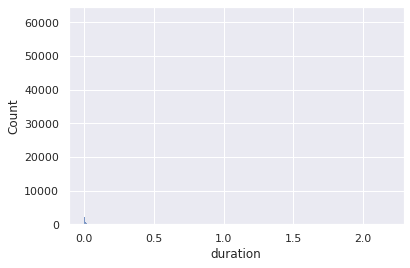

In [18]:
sns.histplot(df.duration[::10])

In [19]:
times = df.groupby('context_mode').duration.sum() / (3600 * 24)
times

context_mode
Recurse    0.493736
SigOnly    0.362635
Name: duration, dtype: float64

In [20]:
times['Recurse'] / (times['Recurse'] + times['SigOnly'])

0.5765445639053565

## Number of slices per function

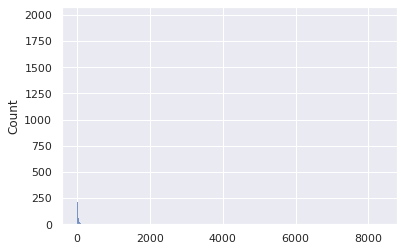

In [21]:
ax = sns.histplot((df.groupby('function_path').size() / 8))
# ax.set_yscale('log')
# ax.set_xscale('log')

In [22]:
len(df) / 8

416957.0

In [23]:
(df.groupby('crate').size() / 8)

crate
rav1e         74667.0
hyper         39981.0
image         38165.0
RustPython    94722.0
rg3d          60798.0
rayon         10535.0
rustls        23658.0
Rocket        12615.0
nalgebra      37143.0
sccache       24673.0
dtype: float64

## Number of instructions

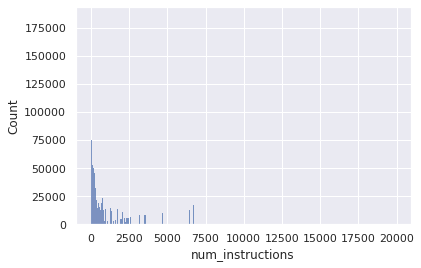

In [24]:
ax = sns.histplot(df.num_instructions)
# ax.set_xscale('log')

In [25]:
df_big = df[df.num_instructions >= 1000]
len(df_big) / len(df)

0.2396386198097166

## Timing

In [26]:
df.groupby(['crate', 'context_mode']).duration.describe()[['count', 'mean', 'std', '50%']]

count      mean       std       50%
crate      context_mode                                        
rav1e      Recurse       298668.0  0.009707  0.029409  0.001279
           SigOnly       298668.0  0.005134  0.010520  0.001168
hyper      Recurse       159924.0  0.054820  0.120390  0.013240
           SigOnly       159924.0  0.040581  0.110859  0.010586
image      Recurse       152660.0  0.001714  0.003062  0.000574
           SigOnly       152660.0  0.001189  0.001819  0.000509
RustPython Recurse       378888.0  0.063868  0.192126  0.007657
           SigOnly       378888.0  0.050199  0.165447  0.003267
rg3d       Recurse       243192.0  0.012658  0.043973  0.001276
           SigOnly       243192.0  0.006845  0.025428  0.001152
rayon      Recurse        42140.0  0.000275  0.000744  0.000045
           SigOnly        42140.0  0.000195  0.000413  0.000040
rustls     Recurse        94632.0  0.013216  0.029372  0.002466
           SigOnly        94632.0  0.006611  0.010517  0.001920
Rocket     Recurse        50460.0  0.016744  0.053903  0.000967
           SigOnly        50460.0  0.016071  0.052799  0.000854
nalgebra   Recurse       148572.0  0.000846  0.001943  0.000241
           SigOnly       148572.0  0.000416  0.000767  0.000168
sccache    Recurse        98692.0  0.012374  0.051854  0.001326
           SigOnly        98692.0  0.009485  0.040907  0.001117

# Relationship between source features and conditions

## Mutability


In [27]:
df2 = df[(df.mutability_mode == 'IgnoreMut') & (df.context_mode == 'Recurse') & (df.pointer_mode == 'Precise')]
cnts = df2.groupby(['has_immut_ptr_in_call', 'ins_rel_nonzero']).instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_immut_ptr_in_call ins_rel_nonzero          
False                 False            0.120996
                      True             0.000115
True                  False            0.425185
                      True             0.453704

In [28]:
# First example was where immediate function didn't have immut ptrs, but a nested call did
df2 = df[~df.has_immut_ptr_in_call]
df2 = df2[(df2.mutability_mode == 'IgnoreMut') & (df2.context_mode == 'Recurse') & (df2.pointer_mode == 'Precise')]
df2[df2.instructions_relative > 0]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
56428,56428,IgnoreMut,Recurse,Precise,13,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,29,7296,...,False,False,False,True,11,0.611111,True,rav1e,True,-0.492476
56436,56436,IgnoreMut,Recurse,Precise,14,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,28,7296,...,False,False,False,True,11,0.647059,True,rav1e,True,-0.435318
56492,56492,IgnoreMut,Recurse,Precise,21,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,29,7296,...,False,False,False,True,15,1.071429,True,rav1e,True,0.068993
56500,56500,IgnoreMut,Recurse,Precise,22,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,28,7296,...,False,False,False,True,15,1.153846,True,rav1e,True,0.143101
320660,320660,IgnoreMut,Recurse,Precise,0,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,54,16359,...,False,False,False,True,1,0.018868,True,rav1e,True,-3.970292
320684,320684,IgnoreMut,Recurse,Precise,3,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,False,False,True,1,0.019231,True,rav1e,True,-3.951244
320692,320692,IgnoreMut,Recurse,Precise,4,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,44,16359,...,False,False,False,True,1,0.023256,True,rav1e,True,-3.761200
320732,320732,IgnoreMut,Recurse,Precise,9,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,False,False,True,1,0.019231,True,rav1e,True,-3.951244
320820,320820,IgnoreMut,Recurse,Precise,20,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,False,False,True,1,0.019231,True,rav1e,True,-3.951244
320868,320868,IgnoreMut,Recurse,Precise,26,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,False,False,True,1,0.019231,True,rav1e,True,-3.951244


## Pointers

In [29]:
df['has_same_type_mut_ptrs'] = df.has_same_type_ptrs_in_call | df.has_same_type_ptrs_in_input
df2 = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'Recurse') & \
              (df.pointer_mode == 'Conservative')]
cnts = df2.groupby(['has_same_type_mut_ptrs','ins_rel_nonzero', ]) \
    .instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_same_type_mut_ptrs ins_rel_nonzero          
False                  False            0.798464
                       True             0.000218
True                   False            0.198793
                       True             0.002525

In [30]:
df2 = df #[(~df.has_same_type_ptrs_in_call) & (df.has_same_type_ptrs_in_input)]
df2 = df2[(df2.mutability_mode == 'DistinguishMut') & (df2.context_mode == 'Recurse') & \
              (df2.pointer_mode == 'Conservative')]
cnts = df2.groupby(['has_same_type_ptrs_in_input','ins_rel_nonzero', ]) \
    .instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_same_type_ptrs_in_input ins_rel_nonzero          
False                       False            0.988066
                            True             0.001921
True                        False            0.009190
                            True             0.000823

In [31]:
df2 = df[(~df.has_same_type_ptrs_in_call) & (~df.has_same_type_ptrs_in_input)]
df2 = df2[(df2.mutability_mode == 'DistinguishMut') & (df2.context_mode == 'Recurse') & (df2.pointer_mode == 'Conservative')]
df2[df2.instructions_relative > 0]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log,has_same_type_mut_ptrs
260417,260417,DistinguishMut,Recurse,Conservative,16,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,17,8797,...,False,False,True,6,0.545455,True,rav1e,True,-0.606136,False
260425,260425,DistinguishMut,Recurse,Conservative,17,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,16,8797,...,False,False,True,6,0.600000,True,rav1e,True,-0.510826,False
260433,260433,DistinguishMut,Recurse,Conservative,18,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,15,8797,...,False,False,True,6,0.666667,True,rav1e,True,-0.405465,False
260441,260441,DistinguishMut,Recurse,Conservative,19,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,11,8797,...,False,False,True,6,1.200000,False,rav1e,True,0.182322,False
260449,260449,DistinguishMut,Recurse,Conservative,20,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,13,8797,...,False,False,True,6,0.857143,True,rav1e,True,-0.154151,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562481,8849,DistinguishMut,Recurse,Conservative,19,"{'start_line': 128, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#4}::read,137,33,10062,...,False,False,True,18,1.200000,True,rustls,True,0.182322,False
2716377,162745,DistinguishMut,Recurse,Conservative,162,"{'start_line': 623, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#23}::read,777,30,10062,...,False,False,True,2,0.071429,True,rustls,True,-2.639057,False
2716409,162777,DistinguishMut,Recurse,Conservative,166,"{'start_line': 623, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#23}::read,777,30,10062,...,False,False,True,2,0.071429,True,rustls,True,-2.639057,False
2739337,185705,DistinguishMut,Recurse,Conservative,107,"{'start_line': 783, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#26}::read,518,30,10062,...,False,False,True,2,0.071429,True,rustls,True,-2.639057,False


## Context

In [141]:
df2 = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'SigOnly') & (df.pointer_mode == 'Precise')]
df2.groupby(['ins_rel_nonzero', 'baseline_reached_library']).num_relevant_instructions.describe()

count        mean         std  \
ins_rel_nonzero baseline_reached_library                                     
False           False                     139695.0    3.469301    6.621981   
                True                      258263.0   90.200102  279.896656   
True            False                        732.0   26.874317   55.467475   
                True                       18267.0  184.707396  215.121801   

                                          min   25%   50%     75%     max  
ins_rel_nonzero baseline_reached_library                                   
False           False                     1.0   1.0   2.0    4.00   516.0  
                True                      2.0  11.0  27.0   67.00  3515.0  
True            False                     3.0   6.0  11.0   36.25   817.0  
                True                      3.0  41.0  99.0  254.00  1282.0

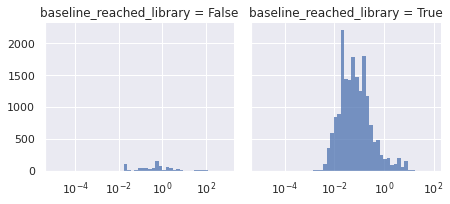

In [144]:
g = sns.FacetGrid(data=df2, col='baseline_reached_library', col_wrap=5, sharex=False)
g.map_dataframe(plot_ins_nz)

# Slice size analysis

In [143]:
def plot_ins(data, xscale='linear', yscale='linear', field='instructions_relative_frac', nz=True, **kwargs):
    if xscale == 'log':
        df_plot = data[data.ins_rel_nonzero]
        bins = np.logspace(np.log10(0.00001), np.log10(df_plot[field].max()))
    else:
        df_plot = data
        bins = 'auto' #np.arange(0, df_plot.instructions_relative_frac.max(), 0.5)
        
    ax = sns.histplot(df_plot[field], bins=bins)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    
    if xscale == 'log' and nz:
        n = data[data.ins_rel_nonzero][field].min() / 10
        ax.bar(n, len(data[~data.ins_rel_nonzero]), color='r', width=[n])
        
plot_ins_nz = lambda *args, **kwargs: plot_ins(*args, xscale='log', yscale='linear', nz=False, **kwargs)
plot_ins_abs = lambda *args, **kwargs: plot_ins(*args, field='instructions_relative', **kwargs)

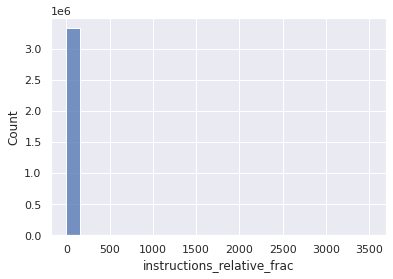

In [107]:
plot_ins(df, 'linear', 'linear')

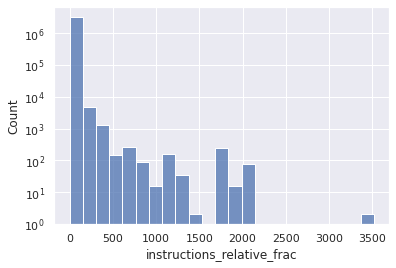

In [100]:
plot_ins(df, 'linear', 'log')

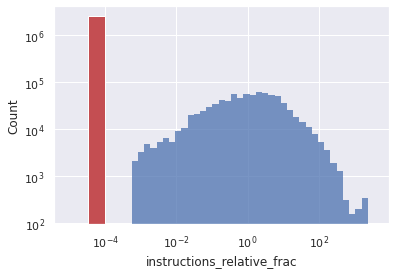

In [95]:
plot_ins(df, 'log', 'log')

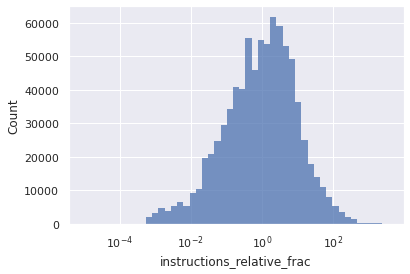

In [101]:
plot_ins_nz(df)

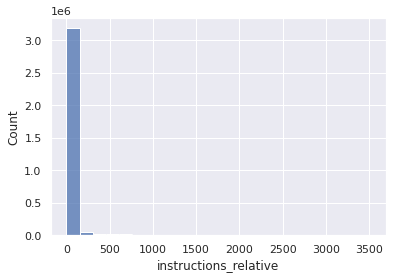

In [102]:
plot_ins_abs(df)

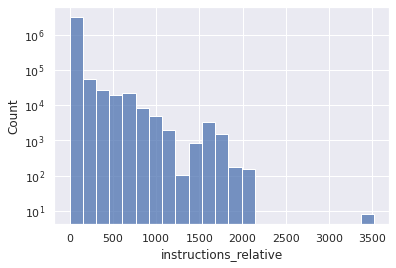

In [112]:
plot_ins_abs(df, yscale='log')

In [109]:
g = sns.FacetGrid(data=df, col='crate', col_wrap=5)
g.map_dataframe(plot_ins_abs, yscale='log')

Error in callback <function flush_figures at 0x7fdb9833ac80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
g = sns.FacetGrid(data=df, col='pointer_mode')
g.map_dataframe(plot_rel_abs)
g.set_titles('{col_name}')

In [ ]:
g = sns.FacetGrid(data=df, col='pointer_mode')
g.map_dataframe(plot_rel_frac, nosize=True)
g.set_titles('{col_name}')

In [ ]:
g = sns.FacetGrid(data=df[df.pointer_mode == 'Precise'], col='mutability_mode', row='context_mode')
g.map_dataframe(plot_rel_abs)
g.set_titles('{col_name}, {row_name}')

In [ ]:
g = sns.FacetGrid(data=df[df.pointer_mode == 'Precise'], col='mutability_mode', row='context_mode')
g.map_dataframe(plot_rel_frac_nz, nosize=True)
g.set_titles('{col_name}, {row_name}')

In [110]:
def frac_analysis(df, factors):
    ins_stats = df[df.instructions_relative_frac > 0].groupby(factors).ins_rel_frac_log.describe()
    ins_stats['frac_nonzero'] = (ins_stats['count'] / df.groupby(factors).size())
    ins_stats['geometric_mean_nonzero'] = np.e ** ins_stats['mean']
    return ins_stats[['geometric_mean_nonzero', 'frac_nonzero', 'count']]

frac_analysis(df, ['mutability_mode', 'context_mode', 'pointer_mode'])

geometric_mean_nonzero  \
mutability_mode context_mode pointer_mode                           
DistinguishMut  Recurse      Conservative                0.195358   
                SigOnly      Conservative                0.079246   
                             Precise                     0.076110   
IgnoreMut       Recurse      Conservative                1.044186   
                             Precise                     0.993429   
                SigOnly      Conservative                1.013047   
                             Precise                     0.970743   

                                           frac_nonzero     count  
mutability_mode context_mode pointer_mode                          
DistinguishMut  Recurse      Conservative      0.002744    1144.0  
                SigOnly      Conservative      0.046957   19579.0  
                             Precise           0.045566   18999.0  
IgnoreMut       Recurse      Conservative      0.456570  190370.0  
                             Precise           0.453819  189223.0  
                SigOnly      Conservative      0.480450  200327.0  
                             Precise           0.478747  199617.0

In [114]:
df_in = df[df.ins_rel_nonzero]
model = Lmer('log(instructions_relative_frac) ~ context_mode + mutability_mode + pointer_mode + (1 | crate)', 
             data=df_in[['instructions_relative_frac', 'context_mode', 'mutability_mode', 'pointer_mode', 'num_relevant_instructions', 'crate']])
model.fit(factors={
    'mutability_mode': ['DistinguishMut', 'IgnoreMut'],
    'context_mode': ['Recurse', 'SigOnly'],
   'pointer_mode': ['Precise', 'Conservative']
})

Formula: log(instructions_relative_frac)~context_mode+mutability_mode+pointer_mode+(1|crate)

Family: gaussian	 Inference: parametric

Number of observations: 819259	 Groups: {'crate': 10.0}

Log-likelihood: -1746052.789 	 AIC: 3492105.579

Random effects:

                 Name    Var    Std
crate     (Intercept)  1.008  1.004
Residual               4.156  2.039

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-1.826,-2.449,-1.204,0.318,9.065,-5.748,0.000,***
context_mode1,0.006,-0.003,0.015,0.005,819246.068,1.267,0.205,
mutability_mode1,1.874,1.853,1.896,0.011,819247.663,173.271,0.000,***
pointer_mode1,-0.054,-0.063,-0.045,0.005,819246.003,-12.020,0.000,***


In [115]:
_, t = model.post_hoc(marginal_vars=['mutability_mode'])
t['Estimate'] = np.exp(-t['Estimate'])
t[['Contrast', 'Estimate', 'P-val', 'Sig']]

,Contrast,Estimate,P-val,Sig
0,DistinguishMut - IgnoreMut,6.514302,0.0,***


In [116]:
_, t = model.post_hoc(marginal_vars=['context_mode'])
t['Estimate'] = np.exp(t['Estimate'])
t[['Contrast', 'Estimate', 'P-val', 'Sig']]

,Contrast,Estimate,P-val,Sig
0,Recurse - SigOnly,0.994018,0.205,
